# 2장 연습문제

In [3]:
# 데이터 불러오기
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

house = load_housing_data()
house.head()

# median_house_value를 예측하는게 목적임

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
house = house.dropna()

In [3]:
house['ocean_proximity'].value_counts()
# island가 5개 뿐이라 분류에 영향을 미칠 것 같으니 drop하도록 하자.

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

In [4]:
house = house.drop(house[house['ocean_proximity']== 'ISLAND'].index)

house['ocean_proximity'].value_counts() # drop 되었다

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
Name: ocean_proximity, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [6]:
X = house.copy().drop("median_house_value", axis=1)
y = house["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [7]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
11757,-121.18,38.75,16.0,2807.0,459.0,1201.0,429.0,4.7941,INLAND
5114,-118.30,33.96,43.0,2009.0,442.0,1095.0,439.0,2.8299,<1H OCEAN
8253,-118.17,33.77,36.0,2933.0,881.0,2077.0,838.0,2.2538,NEAR OCEAN
6809,-118.11,34.10,20.0,3090.0,802.0,2109.0,738.0,3.3801,<1H OCEAN
5268,-118.56,34.06,24.0,2332.0,349.0,761.0,325.0,7.3031,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15443,-117.26,33.19,4.0,2342.0,595.0,1518.0,545.0,2.9469,NEAR OCEAN
2330,-119.72,36.82,16.0,2627.0,613.0,1054.0,623.0,1.9483,INLAND
7656,-118.26,33.82,28.0,5091.0,1074.0,4753.0,1033.0,3.6477,<1H OCEAN
3918,-118.52,34.18,34.0,2307.0,388.0,1168.0,427.0,4.2143,<1H OCEAN


In [8]:
num_attribs = list(X.drop('ocean_proximity', axis=1).columns)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("std_scaler", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

# 드디어 데이터준비가 다 끝났다

In [9]:
# 모델을 만들어보자
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

grid_prams = {'kernel':('linear', 'rbf'), 'C':[0.1, 1,5,10]}
support_vector = SVR()

clf = GridSearchCV(support_vector, grid_prams, n_jobs=-1, return_train_score=True, cv=3, verbose=2)
clf.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10], 'kernel': ('linear', 'rbf')},
             return_train_score=True, verbose=2)

In [10]:
clf.best_params_

{'C': 10, 'kernel': 'linear'}

In [11]:
# 예측과정까지의 전체를 파이프라인으로 만들어보자
from sklearn.pipeline import Pipeline

All_pipeline = Pipeline([('prepare', full_pipeline), ('svm_reg' , SVR(**clf.best_params_))])

All_pipeline.fit(X_train_prepared, y_train)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

# 3장 연습문제

In [79]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [80]:
# 데이터셋 불러오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

X, y = mnist["data"], mnist["target"]
X.shape

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

knn = KNeighborsClassifier()
param_grid = {'weights':['uniform', 'distance'], 'n_neighbors':[3,7,10,15]}

clf = GridSearchCV(knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 7, 10, 15],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [ ]:
clf.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [ ]:
clf.score(X_train,y_train)

1.0

In [ ]:
clf.score(X_test,y_test)

0.9731428571428572

# 3장 연습문제

In [1]:
import numpy as np

In [1]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()   

import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [2]:
train_data.index = train_data['PassengerId']
test_data.index = test_data['PassengerId']
train_data = train_data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
test_data = test_data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


속성은 다음과 같은 의미를 가집니다:
* **PassengerId**: 각 승객의 고유 식별자.
* **Survived**: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
* **Pclass**: 승객 등급. 1, 2, 3등석.
* **Name**, **Sex**, **Age**: 이름 그대로 의미입니다.
* **SibSp**: 함께 탑승한 형제, 배우자의 수.
* **Parch**: 함께 탑승한 자녀, 부모의 수.
* **Ticket**: 티켓 아이디
* **Fare**: 티켓 요금 (파운드)
* **Cabin**: 객실 번호
* **Embarked**: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


In [4]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [5]:
# Embarked의 널값은 두개뿐이라 그냥 drop하는 처리를 했다
train_data = train_data.dropna(axis=0, subset=["Embarked"])

# Age의 널값은 100개가 넘어서 중간값을 넣는 처리를 해줘야 할 것 같다.
train_data.groupby("Pclass")['Age'].median()

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [6]:
train_data1 = train_data[train_data['Pclass'] == 1].fillna(37)
train_data2 = train_data[train_data['Pclass'] == 2].fillna(29)
train_data3 = train_data[train_data['Pclass'] == 3].fillna(24)

df = pd.concat([train_data1, train_data2], ignore_index=True)
train_data = pd.concat([df, train_data3], ignore_index=True)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,female,38.0,1,0,71.2833,C
1,1,1,female,35.0,1,0,53.1000,S
2,0,1,male,54.0,0,0,51.8625,S
3,1,1,female,58.0,0,0,26.5500,S
4,1,1,male,28.0,0,0,35.5000,S


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.7+ KB


In [8]:
# 더미 : Sex, Embarked
# 나이는 연령대로 변경하자

train_data['Agecat'] = pd.cut(train_data['Age'].values, bins=[0,15,30,45,100], labels=['Baby','Young','Mid','Old'])

# SibSp와 Parch는 더해준다 
train_data["Sib+Parch"] = train_data['SibSp'] + train_data['Parch']
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Agecat,Sib+Parch
0,1,1,female,38.0,1,0,71.2833,C,Mid,1
1,1,1,female,35.0,1,0,53.1000,S,Mid,1
2,0,1,male,54.0,0,0,51.8625,S,Old,0
3,1,1,female,58.0,0,0,26.5500,S,Old,0
4,1,1,male,28.0,0,0,35.5000,S,Young,0


In [9]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sib+Parch
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.019314,0.524184,0.382452,32.096681,0.906637
std,0.486260,0.834700,13.209814,1.103705,0.806761,49.697504,1.614703
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,36.500000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000


In [10]:
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Agecat,Sib+Parch
0,1,1,female,38.0,1,0,71.2833,C,Mid,1
1,1,1,female,35.0,1,0,53.1000,S,Mid,1
2,0,1,male,54.0,0,0,51.8625,S,Old,0
3,1,1,female,58.0,0,0,26.5500,S,Old,0
4,1,1,male,28.0,0,0,35.5000,S,Young,0
...,...,...,...,...,...,...,...,...,...,...
884,0,3,female,22.0,0,0,10.5167,S,Young,0
885,0,3,male,25.0,0,0,7.0500,S,Young,0
886,0,3,female,39.0,0,5,29.1250,Q,Mid,5
887,0,3,female,24.0,1,2,23.4500,S,Young,3


In [11]:
# 정답분리
y_train = train_data['Survived']
train_data = train_data.drop('Survived', axis=1)

In [12]:
train_data = train_data.drop("Age", axis=1)
train_data

,Pclass,Sex,SibSp,Parch,Fare,Embarked,Agecat,Sib+Parch
0,1,female,1,0,71.2833,C,Mid,1
1,1,female,1,0,53.1000,S,Mid,1
2,1,male,0,0,51.8625,S,Old,0
3,1,female,0,0,26.5500,S,Old,0
4,1,male,0,0,35.5000,S,Young,0
...,...,...,...,...,...,...,...,...
884,3,female,0,0,10.5167,S,Young,0
885,3,male,0,0,7.0500,S,Young,0
886,3,female,0,5,29.1250,Q,Mid,5
887,3,female,1,2,23.4500,S,Young,3


In [13]:
# 특성변환 해야함 : Sex, Embarked, Age_cat을 더미로

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

onehot = OneHotEncoder()
pipline = ColumnTransformer([('onehot', onehot ,["Sex","Embarked", "Agecat"])], remainder='passthrough')

In [14]:
X_train = pipline.fit_transform(train_data)
#X_test = pipline.transform(test_data)

In [17]:
X_train[0]

array([ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  0.    ,  1.    ,
        0.    ,  0.    ,  1.    ,  1.    ,  0.    , 71.2833,  1.    ])

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=500)  # max_depth

grid_prams = {"max_depth" : [3,4,5]}

clf = GridSearchCV(random_forest, grid_prams, cv=3, n_jobs=-1,verbose=3)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=500),
             n_jobs=-1, param_grid={'max_depth': [3, 4, 5]}, verbose=3)

In [19]:
clf.best_params_

{'max_depth': 3}

In [23]:
clf.score(X_train, y_train)

0.813273340832396

In [26]:
from sklearn.model_selection import cross_val_score

tree = RandomForestClassifier(n_estimators=1000, max_depth=3)

forest_scores = cross_val_score(tree, X_train, y_train, cv=10, n_jobs=-1, verbose=3)
forest_scores.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.6s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    2.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


0.7941011235955056

# 4장 연습문제

In [2]:
# 조기종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현해보자 (싸이킷런은 사용하지 않는다)

from sklearn import datasets

data, target = datasets.load_iris(return_X_y=True)

data.shape, target.shape

((150, 4), (150,))

In [13]:
import seaborn as sns

sns.load_dataset("tips")

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


# 6장

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

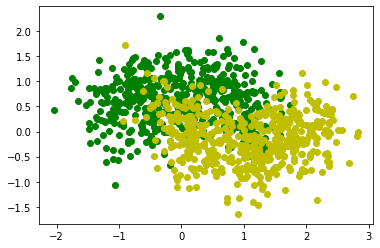

In [41]:
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=1000,noise=0.4)

plt.scatter(X[:,0][y==0], X[:,1][y==0], c='g')
plt.scatter(X[:,0][y==1], X[:,1][y==1], c='y')

In [42]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y)

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier()

grid_params = {"max_leaf_nodes":list(range(10,100))}

grid_search = GridSearchCV(tree_model, grid_params, cv=4, verbose=2)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
[CV] END ..................................max_leaf_nodes=10; total time=   0.0s
[CV] END ..................................max_leaf_nodes=10; total time=   0.0s
[CV] END ..................................max_leaf_nodes=10; total time=   0.0s
[CV] END ..................................max_leaf_nodes=10; total time=   0.0s
[CV] END ..................................max_leaf_nodes=11; total time=   0.0s
[CV] END ..................................max_leaf_nodes=11; total time=   0.0s
[CV] END ..................................max_leaf_nodes=11; total time=   0.0s
[CV] END ..................................max_leaf_nodes=11; total time=   0.0s
[CV] END ..................................max_leaf_nodes=12; total time=   0.0s
[CV] END ..................................max_leaf_nodes=12; total time=   0.0s
[CV] END ..................................max_leaf_nodes=12; total time=   0.0s
[CV] END ..................................max_

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19, 20, 21, 22, 23, 24, 25, 26, 27,
                                            28, 29, 30, 31, 32, 33, 34, 35, 36,
                                            37, 38, 39, ...]},
             verbose=2)

In [44]:
grid_search.best_params_

{'max_leaf_nodes': 25}

In [47]:
from sklearn.metrics import accuracy_score

predict_value = grid_search.predict(X_test)

accuracy_score(y_test, predict_value)

0.852

# 7장 연습문제

In [4]:
import numpy as np
import pandas  as pd
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_test,X_valid,y_test,y_valid = train_test_split(X_test,y_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=100)
extra_tree = ExtraTreesClassifier(n_estimators=100)
svm = SVC()

grid_tree = {"max_depth":list(range(20,50))}
grid_svm = {"C":[0.01,0.1,0.5,1,5,10,20,50,100]}

In [14]:
random_forest_clf = GridSearchCV(random_forest, grid_tree,cv=2,n_jobs=-1)
random_forest_clf.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                       20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]})

In [21]:
print(random_forest_clf.best_estimator_)

random_forest_predict = random_forest_clf.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_test,random_forest_predict)

RandomForestClassifier(max_depth=45)


0.9664761904761905

In [23]:
extra_tree_clf = GridSearchCV(extra_tree, grid_tree, cv=2, n_jobs=-1)
extra_tree_clf.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                       30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                                       40, 41, 42, 43, 44, 45, 46, 47, 48,
                                       49]})

In [25]:
print(extra_tree_clf.best_estimator_)

extra_tree_predict = extra_tree_clf.predict(X_test)

accuracy_score(y_test,extra_tree_predict)

ExtraTreesClassifier(max_depth=38)


0.9692952380952381

In [26]:
svm_clf = GridSearchCV(svm, grid_svm,cv=2, n_jobs=-1)
svm_clf.fit(X_train,y_train)

# 8장 연습문제

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
#mnist.target = mnist.target.astype(np.uint8)

2


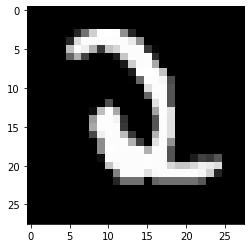

In [31]:
X,y = mnist.data, mnist.target

what = 400

X_sample = X[what].reshape(28,28)
print(y[what])
plt.imshow(X_sample, cmap="gray");

In [35]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y, train_size=0.85)

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=100)

grid_params = {"max_depth":[1500,2000,3000]}

forest_clf = GridSearchCV(random_forest, grid_params, cv=3, n_jobs=-1, verbose=2)
forest_clf.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1500, 2000, 3000]}, verbose=2)

In [50]:
forest_clf.best_estimator_

RandomForestClassifier(max_depth=1500)

In [51]:
forest_clf.score(X_test,y_test)

0.9697142857142858

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_train)

X_pca.shape

(59500, 154)

In [54]:
X_test_pca = pca.transform(X_test)

In [53]:
random_forest_pca = RandomForestClassifier(n_estimators=100, max_depth=1500)
random_forest_pca.fit(X_pca, y_train)

RandomForestClassifier(max_depth=1500)

In [55]:
random_forest_pca.score(X_test_pca, y_test)

0.9465714285714286

In [58]:
# permutauin(n)은 0부터n까지의 array를 만들고, 그의 random한 배열을 출력한다
idx = np.random.permutation(59500)[:10000]

X_train_mini, y_train_mini = X_train[idx], y_train[idx]

X_train_mini.shape

(10000, 784)

In [74]:
y_train_mini = y_train_mini.astype('int')

In [59]:
from sklearn.manifold import TSNE

tsen = TSNE()
X_tsen = tsen.fit_transform(X_train_mini)

c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\user\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


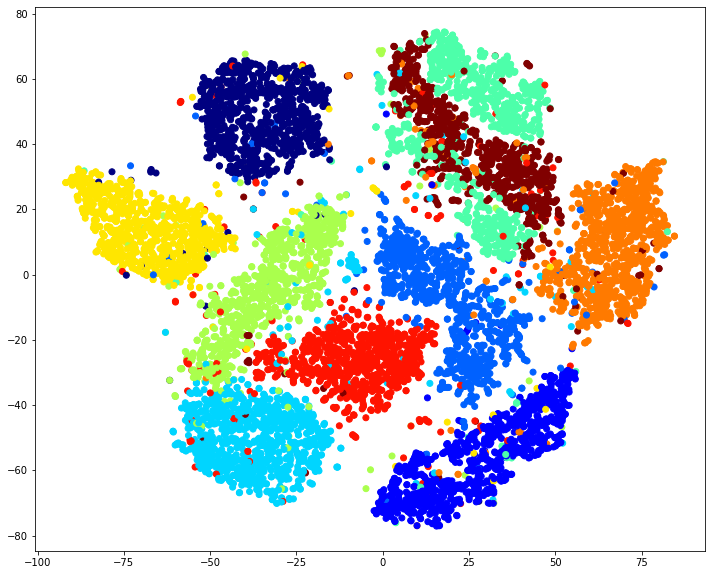

In [78]:
plt.figure(figsize=(12,10))

plt.scatter(X_tsen[:,0], X_tsen[:,1], c=y_train_mini, cmap='jet')

# 9장 연습문제

In [1]:
import numpy as np
import pandas as pd 
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt

In [2]:
X,y = fetch_olivetti_faces(return_X_y=True)
X

array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32)

0


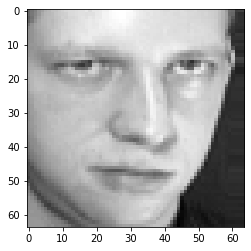

In [20]:
what = 9

X_sample = X[what].reshape(64,64)
print(y[what])
plt.imshow(X_sample, cmap="gray");

In [12]:
# 데이터 shuffle -> label과 동일하게 섞어야 한다

shuffle_idx = np.random.permutation(len(X))

X_shuffle = X[shuffle_idx]
y_shuffle = y[shuffle_idx]

In [13]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_pca = pca.fit_transform(X_shuffle)

In [14]:
pca.n_components_ # 주성분의 수

260

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=40, n_init=30)
kmeans.fit(X_pca)

label = kmeans.labels_

In [19]:
def plot_cluster_face(X,y):
    plt.figure(figsize=(X.shape[0],5))
    for i, (data, label) in enumerate(zip(X,y)):
        plt.subplot(1, X.shape[0], i+1)
        plt.imshow(data, cmap='gray')
        plt.axis("off")
        plt.title(label)

C:\Users\user\AppData\Local\Temp\ipykernel_6260\2211864645.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(X.shape[0],5))


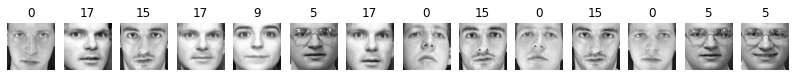

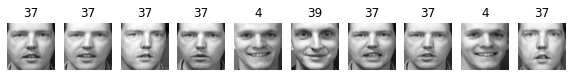

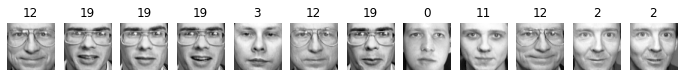

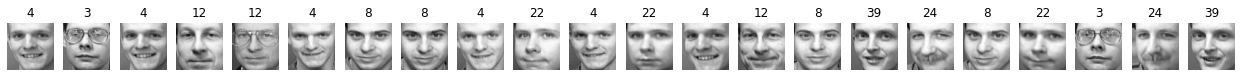

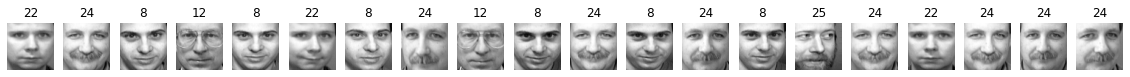

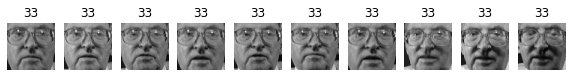

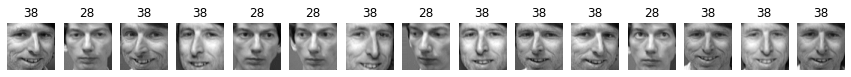

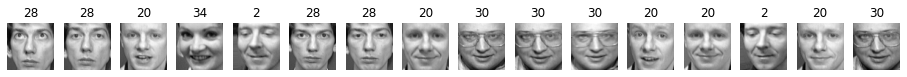

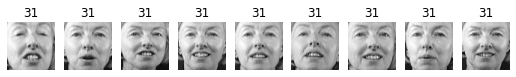

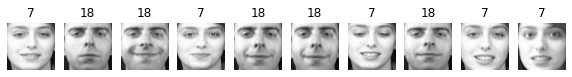

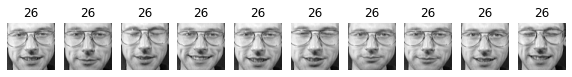

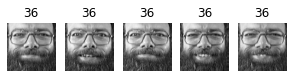

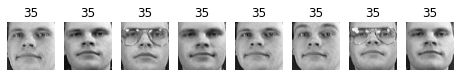

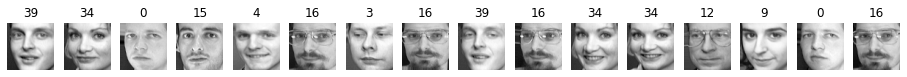

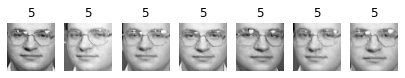

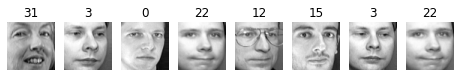

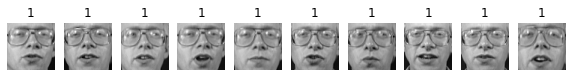

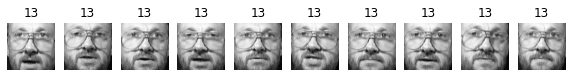

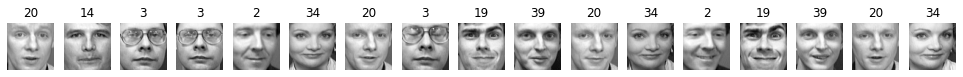

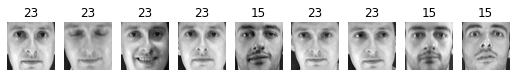

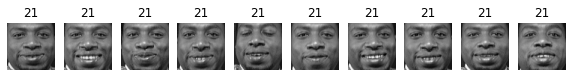

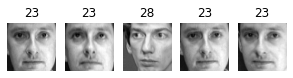

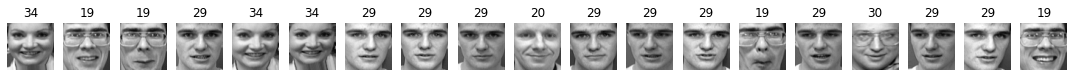

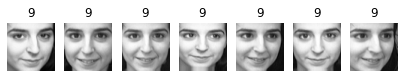

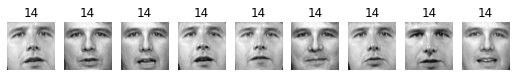

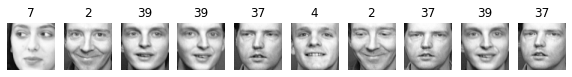

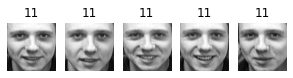

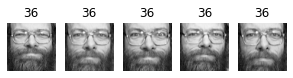

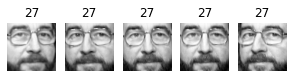

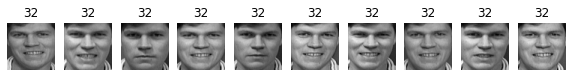

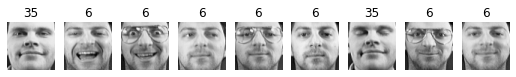

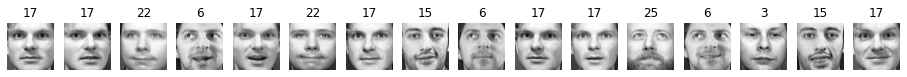

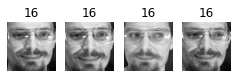

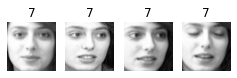

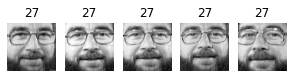

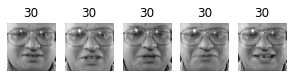

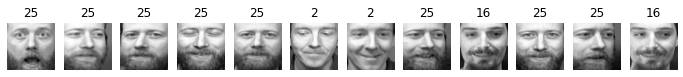

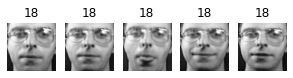

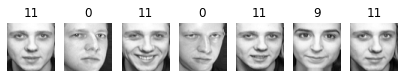

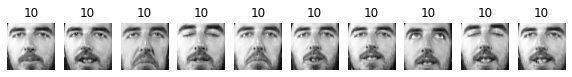

In [22]:
min = np.min(label) 
max= np.max(label)

for i in range(int(min),int(max+1)):
    idx = (label == i)
    same_cluster = X_shuffle[idx]
    same_cluster_label = y_shuffle[idx]
    same_cluster = same_cluster.reshape(-1,64,64)
    plot_cluster_face(same_cluster, same_cluster_label)

C:\Users\user\AppData\Local\Temp\ipykernel_6260\2211864645.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(X.shape[0],5))


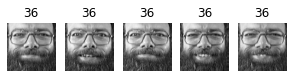

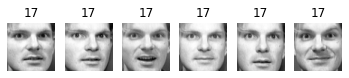

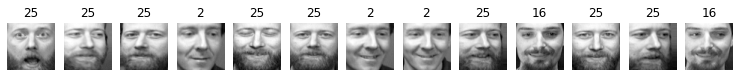

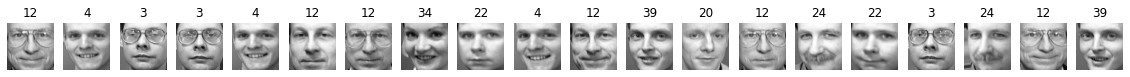

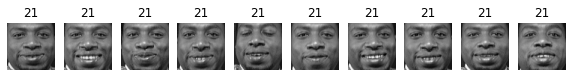

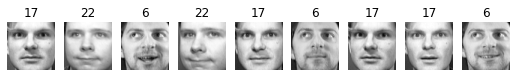

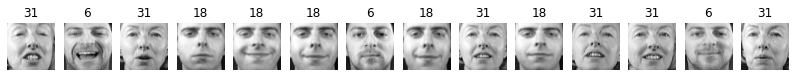

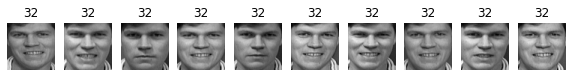

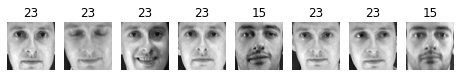

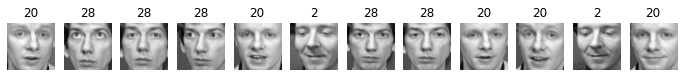

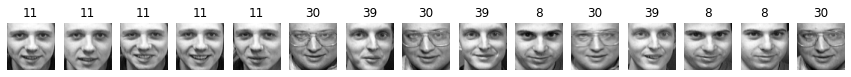

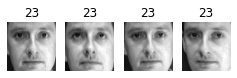

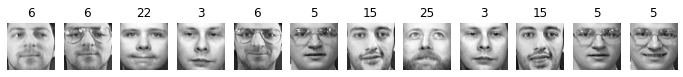

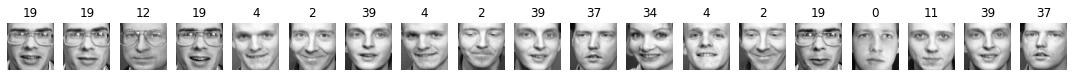

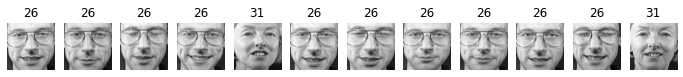

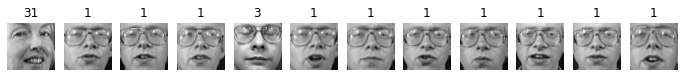

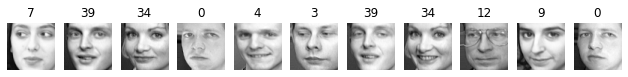

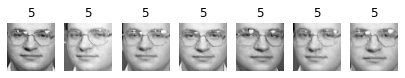

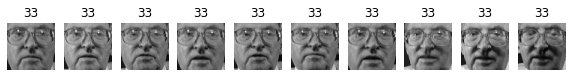

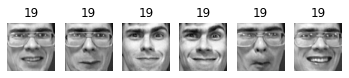

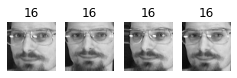

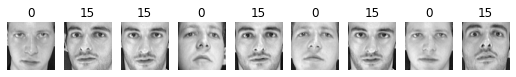

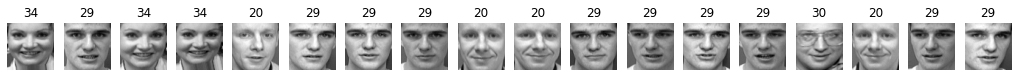

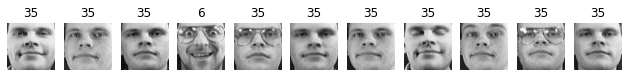

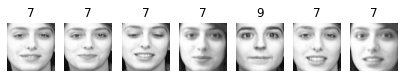

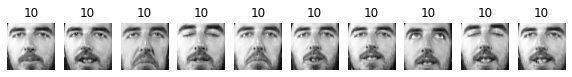

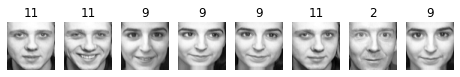

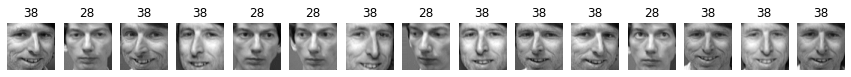

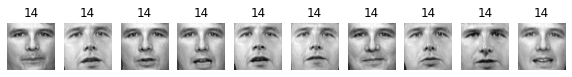

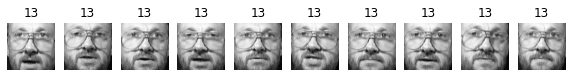

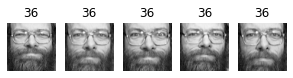

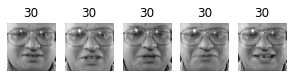

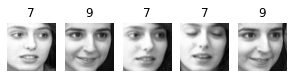

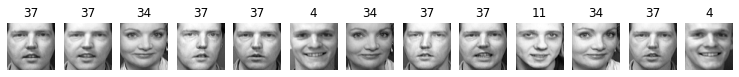

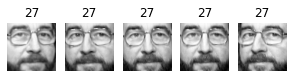

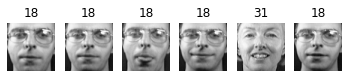

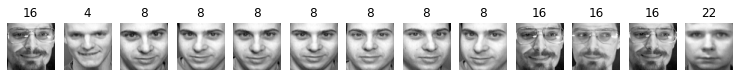

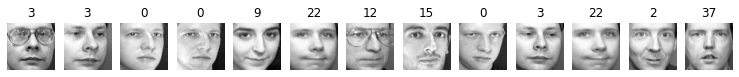

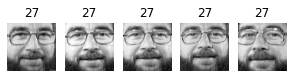

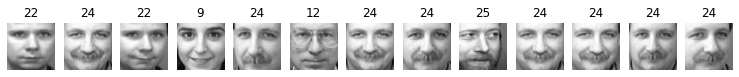

In [23]:
# PCA안 하고 굴려보자

kmeans = KMeans(n_clusters=40, n_init=30)
kmeans.fit(X_shuffle)

label2 = kmeans.labels_

min = np.min(label2) 
max= np.max(label2)

for i in range(int(min),int(max+1)):
    idx = (label2 == i)
    same_cluster = X_shuffle[idx]
    same_cluster_label = y_shuffle[idx]
    same_cluster = same_cluster.reshape(-1,64,64)
    plot_cluster_face(same_cluster, same_cluster_label)

연습 9장 11번

In [25]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X, y, stratify=y, test_size=0.2)

X_train.shape, X_test.shape

((320, 4096), (80, 4096))

In [29]:
# 우선 분류기를 만들어보자

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=300)
param_grid = {"max_depth":[40,45,50,55,60,65,70]}

random_forest_clf = GridSearchCV(random_forest, param_grid=param_grid, cv=3, n_jobs=-1)
random_forest_clf.fit(X_train, y_train)
random_forest_clf.best_estimator_

RandomForestClassifier(max_depth=55, n_estimators=300)

In [32]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train,random_forest_clf.predict(X_train)))
accuracy_score(y_test,random_forest_clf.predict(X_test))

1.0


0.9625

In [33]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("kmeans", KMeans() ),
          ("Randomforest", RandomForestClassifier(n_estimators=300))])

pipe.fit(X_train,y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=70)),
                ('Randomforest', RandomForestClassifier(n_estimators=300))])

In [35]:
print(accuracy_score(y_train, pipe.predict(X_train)))
accuracy_score(y_test,pipe.predict(X_test))

1.0


0.85

In [39]:
pipe = Pipeline([("kmeans", KMeans()),
          ("Randomforest", RandomForestClassifier(n_estimators=300))])

param_grid = {"kmeans__n_clusters":[70,80,90,100,110,120],
              "Randomforest__max_depth":[35,40,45,50,55]}

pipe_clf = GridSearchCV(pipe,param_grid, cv=3,n_jobs=-1, verbose=2)
pipe_clf.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans()),
                                       ('Randomforest',
                                        RandomForestClassifier(n_estimators=300))]),
             n_jobs=-1,
             param_grid={'Randomforest__max_depth': [35, 40, 45, 50, 55],
                         'kmeans__n_clusters': [70, 80, 90, 100, 110, 120]},
             verbose=2)

In [40]:
pipe_clf.best_estimator_

Pipeline(steps=[('kmeans', KMeans(n_clusters=120)),
                ('Randomforest',
                 RandomForestClassifier(max_depth=50, n_estimators=300))])

In [41]:
print(accuracy_score(y_train, pipe_clf.predict(X_train)))
accuracy_score(y_test,pipe_clf.predict(X_test))

1.0


0.85

연습문제 12번

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_pca = pca.fit_transform(X)

gaussian = GaussianMixture(n_components=40, n_init=30)
gaussian.fit(X_pca)

GaussianMixture(n_components=40, n_init=30)

[34]


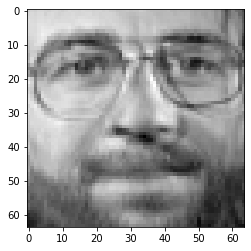

In [48]:
sample, sample_label = gaussian.sample(n_samples=1)

# pca의 역변환을 주어준다
inverse_sample = pca.inverse_transform(sample)

print(sample_label)
plt.imshow(inverse_sample.reshape(64,64), cmap='gray');

In [55]:
X_label = gaussian.predict(X_pca)

X_pca[X_pca == 34]

array([], dtype=float32)

In [56]:
X_pca

array([[-6.432614  , -0.7036626 , -1.43002   , ...,  0.06898256,
        -0.13005699, -0.16854435],
       [-1.075908  , -6.697331  ,  1.8428087 , ..., -0.0272154 ,
        -0.07037374,  0.07683308],
       [-5.292954  , -1.5425038 ,  0.22595549, ..., -0.13830711,
        -0.05147091,  0.06331746],
       ...,
       [ 2.0407639 , -1.5096122 ,  3.4487329 , ...,  0.08766174,
         0.08621899,  0.01713722],
       [-5.165227  ,  8.096766  , -0.67101085, ..., -0.09195706,
        -0.0898765 , -0.02437668],
       [-1.1505    ,  2.4350357 ,  1.1894937 , ...,  0.03526788,
         0.01012634, -0.01756207]], dtype=float32)

In [64]:
X_inverse = pca.inverse_transform(X_pca)
#mse = np.square(X_inverse - X).mean(axis=-1)

In [67]:
np.mean(X_inverse[0] - X[0])

3.1576412e-05

In [81]:
np.square(X_inverse - X).mean(axis=1)

array([2.60870089e-04, 1.66103317e-04, 1.63985736e-04, 2.75981671e-04,
       1.07293992e-04, 9.46849832e-05, 2.12709449e-04, 2.80310458e-04,
       1.14908296e-04, 5.92470751e-05, 9.64179198e-05, 9.81345438e-05,
       4.74121480e-05, 8.12369544e-05, 4.93562329e-05, 2.45527423e-04,
       1.09129687e-04, 2.10281869e-04, 1.90464518e-04, 1.74998349e-04,
       2.86536524e-04, 2.03175208e-04, 2.27194017e-04, 2.47047981e-04,
       1.78365241e-04, 1.18043194e-04, 1.76890637e-04, 1.63795718e-04,
       2.62476795e-04, 2.63136753e-04, 6.95301424e-05, 6.66545093e-05,
       3.15970392e-05, 2.81954242e-04, 2.57962558e-04, 1.31197070e-04,
       3.10796691e-04, 5.22184018e-05, 5.66816707e-05, 1.57567876e-04,
       2.44102906e-04, 2.97679595e-04, 2.73197656e-04, 2.32702834e-04,
       2.81705841e-04, 2.86944007e-04, 2.63102207e-04, 1.65941296e-04,
       2.32623337e-04, 2.50687968e-04, 3.45812296e-04, 3.29620379e-04,
       2.86751252e-04, 2.66984280e-04, 2.23607043e-04, 3.18940671e-04,
      

# 10장 연습문제

반복마다 학습률을 조금씩 상승시키면서, 모델의 손실을 확인한다

최적의 학습률은 최대 학습률(알고리즘이 발산을 시작하는 학습률)의 절반 정도

In [37]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras

In [38]:
# 데이터를 불러옵니다
(X_train, y_train), (X_test,y_test) = keras.datasets.mnist.load_data()

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, y_train.shape, X_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28))

In [44]:
# 모델을 만듭니다
keras.backend.clear_session()

input_ = keras.layers.Input(shape=X_train.shape[1:])
flatten = keras.layers.Flatten(input_shape=[28,28])(input_)
hidden1 = keras.layers.Dense(100,activation="relu")(flatten)
hidden2 = keras.layers.Dense(50, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(30, activation="relu")(hidden2)
output = keras.layers.Dense(10, activation="softmax")(hidden3)
model = keras.Model(inputs=[input_], outputs=[output])

# 조기종료 콜백
earlystop_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# 콜백은 반복마다 학습률과 손실을 기록합니다:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr)) #학습률을 가져온다
        self.losses.append(logs["loss"])                        # 학습로그에서 loss를 저장한다
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

1688/1688 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.4932 - val_loss: nan - val_accuracy: 0.0978


Text(0, 0.5, 'Loss')

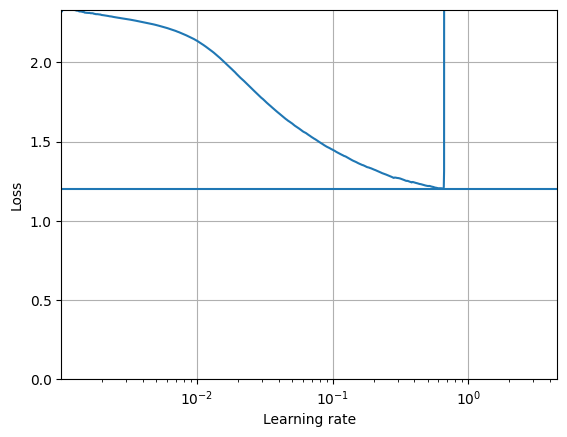

In [45]:
# 작은 학습률 1e-3에서 시작하여 반복마다 0.5%씩 증가합니다:
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=1, # 한 에포크 동안 학습
                    validation_split=0.1, callbacks=[expon_lr])

# 학습률에 따른 그래프 그리기
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

# 학습률이 6e-1 (0.6)을 지날 떄 손실이 갑자기 솟구치기 때문에 3e-1을 학습률로 사용하겠습니다:

Epoch 1/30
1688/1688 [==============================] - 8s 4ms/step - loss: 0.3308 - accuracy: 0.8992 - val_loss: 0.1213 - val_accuracy: 0.9657
Epoch 2/30
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1403 - accuracy: 0.9584 - val_loss: 0.0981 - val_accuracy: 0.9705
Epoch 3/30
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1055 - accuracy: 0.9684 - val_loss: 0.1110 - val_accuracy: 0.9663
Epoch 4/30
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0832 - accuracy: 0.9741 - val_loss: 0.0879 - val_accuracy: 0.9728
Epoch 5/30
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0723 - accuracy: 0.9776 - val_loss: 0.0929 - val_accuracy: 0.9750
Epoch 6/30
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0604 - accuracy: 0.9819 - val_loss: 0.0839 - val_accuracy: 0.9763
Epoch 7/30
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0531 - accuracy: 0.9836 - val_loss: 0.0965 - val_accuracy:

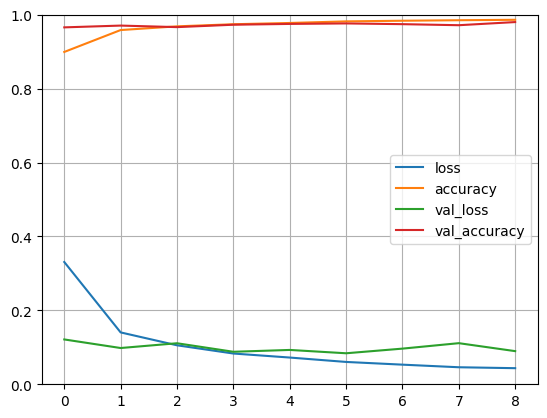

In [46]:
# 찾은 학습률로 모델을 다시 훈련시킨다
keras.backend.clear_session()

input_ = keras.layers.Input(shape=X_train.shape[1:])
flatten = keras.layers.Flatten(input_shape=[28,28])(input_)
hidden1 = keras.layers.Dense(100,activation="relu")(flatten)
hidden2 = keras.layers.Dense(50, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(30, activation="relu")(hidden2)
output = keras.layers.Dense(10, activation="softmax")(hidden3)
model = keras.Model(inputs=[input_], outputs=[output])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=30,
                    callbacks=[earlystop_cb], validation_split=0.1)

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1);

In [47]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0953 - accuracy: 0.9728


[0.09530065953731537, 0.9728000164031982]

# 11장 연습문제